In [2]:
%%capture
!pip install lightning

In [3]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn import (
    Sequential as Seq,
    Linear as Lin,
    ReLU,
    BatchNorm1d,
    AvgPool1d,
    Sigmoid,
    Conv1d,
)
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import pickle

#Architecture

In [6]:
class Phi(nn.Module):
    def __init__(self,input_dim: int, output_dim: int = 10):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.phi = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, P):
        '''
        takes in B x N x M tensor, where B is the batch dimension, N is the number of polymers in the blend, and
        M is the number of monomers
        Outputs B x N x self.output_dim tensor
        '''
        c = P.sum(dim = -1, keepdim = True) #blending coefficients
        P_ = P / c
        P_[P_ != P_] = 0 #check for divide by zero error
        P_r = self.phi(P_)
        return P_r * c

class Rho(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.input_dim = input_dim

        self.rho = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(),
            nn.Linear(self.input_dim, 1)
        )

    def forward(self, x):
        x = self.rho(x)
        return x

class Pool(nn.Module):
    def __init__(self, pool_func = (lambda x: x.sum(dim = -2))):
        super().__init__()
        self.pool_func = pool_func

    def forward(self, x):
        return self.pool_func(x)

class LitDeepSets(pl.LightningModule):
    def __init__(self, phi, rho, pool = None, lr = 2e-3):
        super().__init__()
        self.phi = phi
        self.rho = rho
        self.pool = pool if pool else lambda x: x.sum(dim = -2) #default is summation
        self.train_loss = []
        self.val_loss = []
        self.lr = lr

    def forward(self, x):
        x_r = self.pool(self.phi(x))
        y_hat = self.rho(x_r)
        return y_hat

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        y_hat = torch.squeeze(self.forward(x))
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.train_loss.append(loss.item())
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.forward(x)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = torch.squeeze(self.forward(x))
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.val_loss.append(loss.item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        return optimizer


#Dataloader

In [7]:
def convert_vector_to_representation(vector, library, output_shape = None):
    '''
    vector is N_parents dimensional blend vector
    library is N_parents x N_monomers array of parent polymers
    output_shape is the shape of the blend representation
    '''
    N_parents, = vector.shape
    if N_parents != library.shape[0]:
        raise ValueError('library is of incorrect size')

    all_polymers = library * vector[:, np.newaxis]
    rep = all_polymers[~np.all(all_polymers == 0, axis=1)]

    if output_shape:
        n, m = rep.shape
        if n > output_shape[0]:
            raise ValueError('blend is larger than specified output shape')
        padded_rep = np.zeros(output_shape)
        padded_rep[:n,:m] = rep
        return padded_rep
    return rep

def parse_data(library, data):
    """
    library is N_parents x N_monomers array of parent polymers (48 x 3)
    data is N_samples x (N_parents + 1) array of blending data, with turbidities concatenated
    as the last column
    """
    blends = data[:,:-1]
    turbidities = data[:,-1]

    N_parents, N_monomers = library.shape
    where = np.where(blends > 10**-6, 1, 0)
    _ = np.sum(where, axis = 1)
    blend_capacity = np.max(_)
    output_shape = (blend_capacity, N_monomers)

    reps = [
        convert_vector_to_representation(blends[i], library, output_shape)
        for i in range(blends.shape[0])
    ]

    return np.array(reps), turbidities

class RHPs_Dataset(Dataset):
    def __init__(self, polymers, activities):
        self.sets = polymers
        self.activity = activities

    def __len__(self):
        return self.sets.shape[0]

    def __getitem__(self, idx):
        return self.sets[idx], self.activity[idx]

#test on fix 2mer data

In [8]:
path = "/content/drive/MyDrive/PairwiseBlendingFullResults/full_data_with_delta.csv"
data = pd.read_csv(path, header = None).to_numpy()
library = pd.read_csv("/content/drive/MyDrive/PairwiseBlendingFullResults/3_1_24.csv", header=None)
library = library.to_numpy()[:48, :]
library = library / np.sum(library, axis = 1, keepdims = True)

In [14]:
reps, delta = parse_data(library, data)
delta = -1*delta

X_train, X_val, y_train, y_val = train_test_split(
        reps, delta, test_size=0.33, random_state=42
    )

train_dataset = RHPs_Dataset(X_train.astype(np.float32), y_train.astype(np.float32))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = RHPs_Dataset(X_val.astype(np.float32), y_val.astype(np.float32))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [15]:
N_monomers = 3
embed_dim = 6
lr = 10e-3

phi = Phi(N_monomers,embed_dim)
rho = Rho(embed_dim)

deepsets = LitDeepSets(
    phi,
    rho,
    lr = lr
)

In [16]:
max_epochs = 200

trainer = pl.Trainer(max_epochs = max_epochs, log_every_n_steps = 4, check_val_every_n_epoch=10)
trainer.fit(model=deepsets, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params | Mode 
--------------------------------------
0 | phi  | Phi  | 66     | train
1 | rho  | Rho  | 49     | train
--------------------------------------
115       Trainable params
0         Non-trainable params
115       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


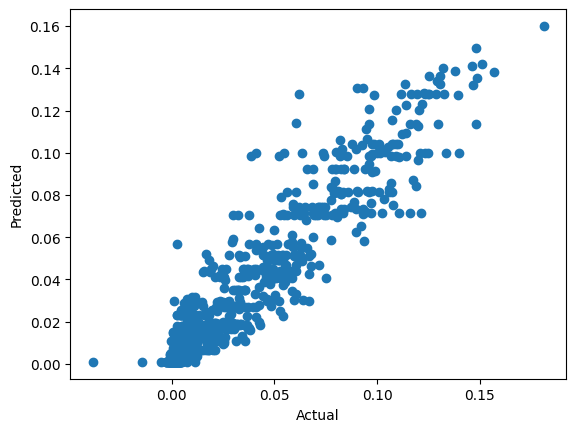

**r^2 = 0.9115130507202418**
**MSE = 9.490037240130909e-05


In [17]:
pred = deepsets(torch.from_numpy(X_val.astype(np.float32)))
pred = np.squeeze(pred.detach().numpy())


plt.scatter(y_val, pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

from sklearn.metrics import r2_score
print(f'**r^2 = {r2_score(y_val, pred)}**')
print(f'**MSE = {np.average((y_val - pred)**2)}')

In [18]:
path = "/content/drive/MyDrive/20240528_fix_full_2mer/results/full_data_with_delta.csv"
data = pd.read_csv(path, header = None).to_numpy()
library = pd.read_csv("/content/drive/MyDrive/PairwiseBlendingFullResults/3_1_24.csv", header=None)
library = library.to_numpy()[:48, :]
library = library / np.sum(library, axis = 1, keepdims = True)

In [19]:
reps, delta = parse_data(library, data)

X_train, X_val, y_train, y_val = train_test_split(
        reps, delta, test_size=0.33, random_state=42
    )

train_dataset = RHPs_Dataset(X_train.astype(np.float32), y_train.astype(np.float32))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = RHPs_Dataset(X_val.astype(np.float32), y_val.astype(np.float32))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

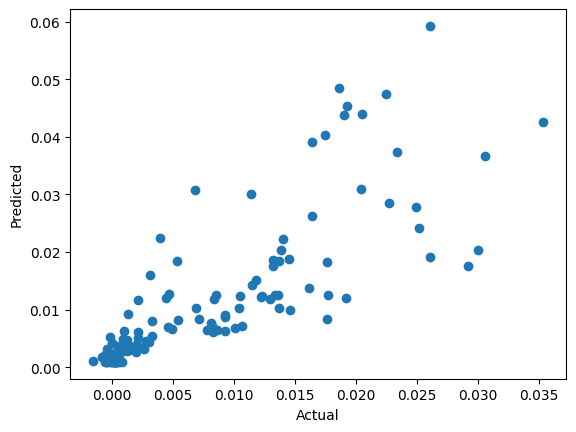

**r^2 = 0.03207383994755442**
**MSE = 7.123291773979328e-05


In [20]:
pred = deepsets(torch.from_numpy(X_val.astype(np.float32)))
pred = np.squeeze(pred.detach().numpy())


plt.scatter(y_val, pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

from sklearn.metrics import r2_score
print(f'**r^2 = {r2_score(y_val, pred)}**')
print(f'**MSE = {np.average((y_val - pred)**2)}')